In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns

In [10]:
df_desc = pd.read_excel('../data/spy_data.xlsx', sheet_name='descriptions')
df_prices = pd.read_excel('../data/spy_data.xlsx', sheet_name='prices')
df_returns = pd.read_excel('../data/spy_data.xlsx', sheet_name='total returns').set_index('date')

In [11]:
df_returns.head()

,SPY,^IRX
date,,
1994-01-04,0.004035,0.000122
1994-01-05,0.002009,0.000122
1994-01-06,0.000000,0.000121
1994-01-07,0.006016,0.000119
1994-01-10,0.011960,0.000119


In [16]:
df_returns['SPY Excess'] = df_returns['SPY'] - df_returns['^IRX']
rets = df_returns['SPY Excess']

In [18]:
# 1.1


5% VaR backtest: 5.63%


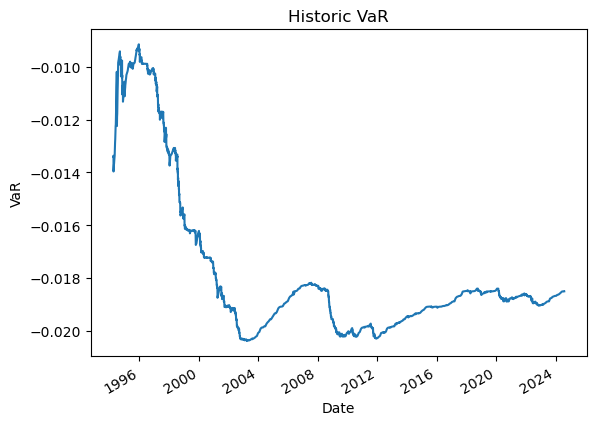

In [19]:
historic_VaR = rets.shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot(title = 'Historic VaR', ylabel = 'VaR', xlabel = 'Date')
exceed = sum(rets < historic_VaR)/len(historic_VaR.dropna())
print('5% VaR backtest: {:,.2%}'.format(exceed))

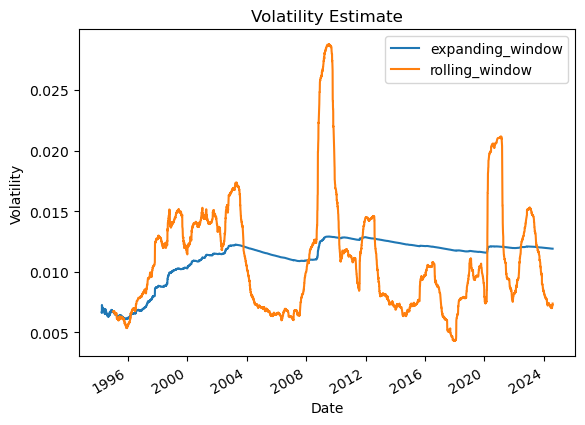

In [24]:
# 1.2 
import matplotlib.pyplot as plt
expending_window = np.sqrt((rets**2).expanding(60).mean().shift())
rolling_window = np.sqrt((rets**2).rolling(252).mean().shift())
theta = 0.94
ewma[i] = np.sqrt(**2 * theta + (1-theta) * rets.loc[ind]**2)
std = pd.DataFrame({'expanding_window': expending_window, 'rolling_window': rolling_window})
std.plot(title = 'Volatility Estimate',ylabel = 'Volatility', xlabel = 'Date')
plt.show()

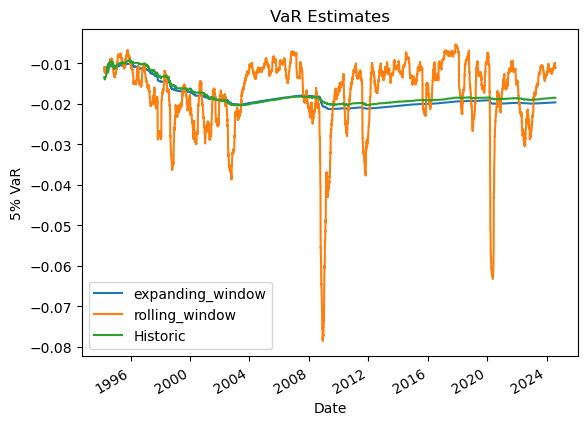

In [22]:
VaR = -1.65 * std
VaR['Historic'] = historic_VaR

VaR.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')
plt.show()